In [5]:
# 문제1) 데이터 설명 : 혈압 데이터 DBP(종속변수 : DBP)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf

import pandas as pd
df_1 = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/30/p1.csv')
df_1.head()

,Age,Gender,BMI,DBP,FPG,Chol,Tri,HDL,LDL,ALT,CCR,FFPG
0,26,1,20.1,81,5.80,4.36,0.86,0.90,2.43,12.0,63.8,5.40
1,40,1,17.7,54,4.60,3.70,1.02,1.50,2.04,9.2,70.3,4.10
2,40,2,19.7,53,5.30,5.87,1.29,1.75,3.37,10.1,61.1,4.85
3,43,1,23.1,71,4.50,4.05,0.74,1.27,2.60,36.5,73.4,5.30
4,36,1,26.5,82,5.54,6.69,3.49,0.91,3.64,69.3,67.5,5.53


In [6]:
# 1-1.EDA를 시행하라
df_1.describe(include="all")

,Age,Gender,BMI,DBP,FPG,Chol,Tri,HDL,LDL,ALT,CCR,FFPG
count,4303.000000,4303.000000,4303.000000,4303.000000,4303.000000,4302.000000,4303.000000,4303.000000,4303.000000,4303.000000,4303.000000,4303.000000
mean,48.085057,1.351615,24.123923,76.360446,5.226368,4.860732,1.588476,1.666765,2.976220,26.754810,71.557080,5.729084
std,14.686155,0.477530,3.397294,11.004056,0.781089,0.925484,1.260003,1.079377,0.892196,22.279922,16.937394,1.424568
min,22.000000,1.000000,15.600000,45.000000,1.780000,1.650000,0.000000,0.000000,0.540000,4.500000,4.860753,3.200000
25%,35.000000,1.000000,21.700000,69.000000,4.700000,4.200000,0.860000,1.130000,2.350000,14.300000,60.000000,4.900000
50%,46.000000,1.000000,24.000000,76.000000,5.140000,4.790000,1.280000,1.340000,2.820000,20.500000,72.000000,5.300000
75%,59.000000,2.000000,26.300000,83.000000,5.700000,5.430000,1.940000,1.610000,3.420000,31.050000,82.300000,6.020000
max,93.000000,2.000000,45.800000,134.000000,6.990000,11.650000,32.640000,4.860753,6.270000,436.200000,307.000000,29.700000


<Axes: >

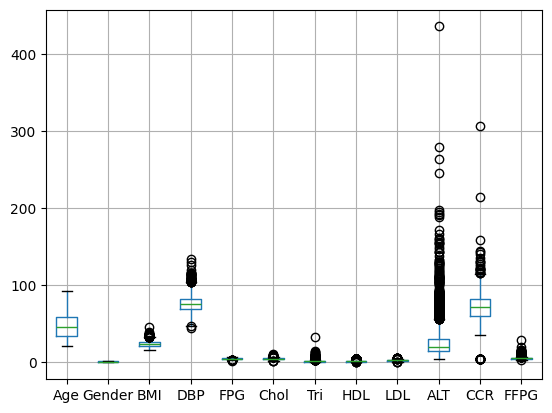

In [7]:
df_1.boxplot()

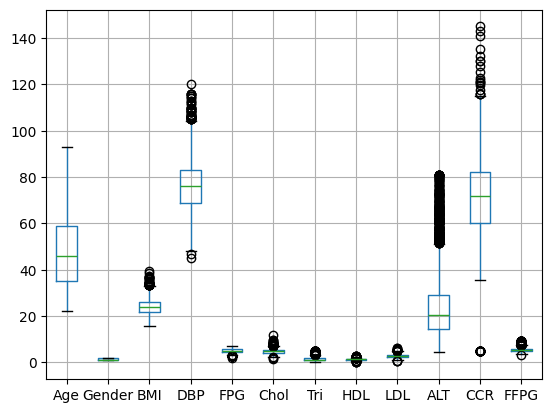

In [8]:
def remove_outier(data):
    
    Q3=np.quantile(data,0.75)
    Q1=np.quantile(data,0.25)
    
    IQR=Q3-Q1
    upper_limit=Q3+IQR*3
    lower_limit=Q1-IQR*3
    
    condition = (data>=upper_limit)|(data<=lower_limit)
    
    return condition
#TRI,ALT,CCR,FFPG OUTLIER 제거
df_2=pd.DataFrame()
for col in df_1.columns:
    df_2[col]=df_1[col][~remove_outier(df_1[col])]
df_2=df_2.fillna(df_2.mean())
df_2.boxplot()
plt.show()

In [9]:
# 1-3.train test set을 DBP컬럼 기준으로 7:3 비율로 나누고 잘 나뉘었는지 통계적으로 나타내라
df_2['DBP_bin'] = pd.qcut(df_2['DBP'], q=4, labels=False)
train_set, test_set = train_test_split(df_2,stratify=df_2['DBP_bin'], test_size=0.3, random_state=42)

# train과 test set에서 특정 컬럼의 값의 분포 확인
train_distribution = train_set['DBP'].value_counts()
test_distribution = test_set['DBP'].value_counts()

# 카이제곱 검정을 사용하여 두 데이터셋 간의 분포가 유의미한지 확인
chi2_stat, p_val, dof, expected = stats.chi2_contingency(pd.concat([train_distribution, test_distribution], axis=1).fillna(0))
print("Chi-squared test statistic:", chi2_stat)
print("P-value:", p_val)
# 두 분포가 같다. 


Chi-squared test statistic: 65.3505186374371
P-value: 0.6971193214631687


In [10]:
# 2-1.독립변수의 차원축소의 필요성을 논하고, 필요에 따라 차원을 축소하고 불필요하다면 그 근거를 논하시오
from statsmodels.api import OLS
import statsmodels.api as sm

from statsmodels.formula.api import ols
# X = df[["X1", "X2"]]   # DataFrame
# y = df["y"]            # Series
# X = sm.add_constant(X) # 절편 추가
# model = sm.OLS(y, X)
model_ols=OLS(train_set['DBP'],sm.add_constant(train_set[[c for c in train_set.columns if c !='DBP']])).fit()
model_ols.summary()
# 2-2.작업 후 데이터가 회귀분석의 기본가정 따르는지 설명
# -Omnibus: Omnibus 테스트는 모델의 잔차가 정규 분포를 따르는지를 검정하는 것입니다. Omnibus 값이 작고, p-value가 작으면 모델의 잔차가 정규 분포를 따른다는 가설을 기각할 수 있습니다. 여기서는 Omnibus 값이 43.956이고, p-value가 0.000으로 유의수준 0.05보다 작으므로 모델의 잔차가 정규 분포를 따르지 않음을 나타냅니다.
# -Durbin-Watson: Durbin-Watson 통계량은 잔차의 자기상관을 검정하는 것입니다. 값이 2에 가까우면 자기상관이 없다고 판단됩니다. 여기서 Durbin-Watson 값은 1.985로 2에 가까우므로 자기상관이 없다고 볼 수 있습니다.
# -Jarque-Bera (JB): Jarque-Bera 테스트는 잔차의 왜도(skewness)와 첨도(kurtosis)가 정규 분포를 따르는지를 검정합니다. JB 값이 크고, p-value가 작으면 모델의 잔차가 정규 분포를 따르지 않음을 나타냅니다. 여기서 JB 값이 56.783이고, p-value가 매우 작으므로 모델의 잔차가 정규 분포를 따르지 않음을 나타냅니다.
# -Skew: 잔차의 왜도를 나타냅니다. 왜도가 0에 가까울수록 정규 분포에 가깝습니다.
# -Kurtosis: 잔차의 첨도를 나타냅니다. 첨도가 3에 가까울수록 정규 분포에 가깝습니다.
# -Cond. No.: 조건수(Condition Number)는 다중공선성을 측정하는 지표입니다. 조건수가 클수록 다중공선성이 존재할 가능성이 높습니다. 여기서는 311로 표시되었습니다.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    DBP   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     1507.
Date:                Wed, 08 Oct 2025   Prob (F-statistic):               0.00
Time:                        12:20:06   Log-Likelihood:                -8519.7
No. Observations:                3012   AIC:                         1.707e+04
Df Residuals:                    2999   BIC:                         1.714e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         60.5376      1.062     56.984      0.000      58.455      62.621
Age            0.0171      0.006      2.850      0.004       0.005       0.029
Gender        -0.2506      0.216     -1.159      0.246      -0.675       0.173
BMI            0.0777      0.027      2.858      0.004       0.024       0.131
FPG            0.0246      0.119      0.206      0.837      -0.209       0.258
Chol          -0.0024      0.118     -0.021      0.984      -0.235       0.230
Tri            0.1586      0.104      1.531      0.126      -0.045       0.362
HDL           -0.0296      0.299     -0.099      0.921      -0.617       0.557
LDL           -0.0727      0.119     -0.613      0.540      -0.305       0.160
ALT            0.0087      0.006      1.406      0.160      -0.003       0.021
CCR           -0.0032      0.006     -0.534      0.594      -0.015       0.008
FFPG           0.1929      0.096      2.009      0.045       0.005       0.381
DBP_bin        8.5841      0.071    120.282      0.000       8.444       8.724
==============================================================================
Omnibus:                      729.267   Durbin-Watson:                   1.889
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3989.703
Skew:                           1.038   Prob(JB):                         0.00
Kurtosis:                       8.242   Cond. No.                     1.35e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.35e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
# 3-1.회귀분석 알고리즘 3개를 선택하고 선정이유와 장단점 비교

# - 선형 회귀 (Linear Regression):

# 장점:간단하고 이해하기 쉬움.계산이 빠름.설명력이 높음.
# 단점:선형성 가정을 만족해야 함.이상치에 민감함.다중공선성에 취약함.

# - 릿지 회귀 (Ridge Regression):

# 장점:다중공선성 문제를 완화함.과적합을 줄임.
# 단점:모델 해석이 어려울 수 있음.모든 변수가 모델에 포함되어 예측에 영향을 줄 수 있음.

# - 라쏘 회귀 (Lasso Regression):

# 장점:변수 선택 기능을 제공하여 모델 해석이 용이함.다중공선성 문제를 해결함
# 단점:과적합을 줄이기 위해 튜닝이 필요함.데이터의 특징을 잘 파악해야 함.

# - 엘라스틱넷 회귀 (ElasticNet Regression):

# 장점:릿지와 라쏘의 장점을 결합하여 다양한 상황에 유연하게 대응함.
# 단점:두 개의 하이퍼파라미터 조정이 필요하여 모델 튜닝이 복잡함.

# - 결정 트리 회귀 (Decision Tree Regression):

# 장점:비선형 관계를 모델링할 수 있음.이해하기 쉬움.
# 단점:과적합될 수 있음.작은 변화에도 크게 변동될 수 있음.

# - 랜덤 포레스트 회귀 (Random Forest Regression):

# 장점:과적합을 줄임.다양한 종류의 데이터에 적용 가능.
# 단점:해석이 어려울 수 있음.계산 비용이 높을 수 있음.

# - 그래디언트 부스팅 회귀 (Gradient Boosting Regression):

# 장점:앙상블 학습을 통해 성능을 향상시킴.이상치에 강함.
# 단점:모델 튜닝이 필요함.계산 비용이 높을 수 있음.

# 3-2.1-3에서 구분한 데이터를 기준으로 3개의 회귀 분석 모델링을 진행하고 평가지표 rmse로 가장 최적화된 알고리즘 선정
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRFRegressor
from sklearn.ensemble import AdaBoostRegressor

model_lr=LinearRegression()
model_DT=DecisionTreeRegressor()
model_XBBRFR=XGBRFRegressor()
X_train=train_set[[c for c in train_set.columns if c !='DBP']]
y_train=train_set['DBP']
X_test=test_set[[c for c in train_set.columns if c !='DBP']]
y_test=test_set['DBP']
model_lr.fit(X_train,y_train)
model_DT.fit(X_train,y_train)
model_XBBRFR.fit(X_train,y_train)

model_lr_pred=model_lr.predict(X_test)
model_DT_pred=model_DT.predict(X_test)
model_XBBRFR_pred=model_XBBRFR.predict(X_test)

from sklearn.metrics import mean_squared_error
print("LinearRegression",mean_squared_error(y_test,model_lr_pred))
print("DecisionTreeRegressor",mean_squared_error(y_test,model_DT_pred))
print("XGBRFRegressor",mean_squared_error(y_test,model_XBBRFR_pred))

print("---------------------------------------------")

#성능 너무 안좋음
print("LinearRegression",model_lr.score(X_test,y_test))
print("DecisionTreeRegressor",model_DT.score(X_test,y_test))
print("XGBRFRegressor",model_XBBRFR.score(X_test,y_test))


LinearRegression 18.534825928707725
DecisionTreeRegressor 34.74241782410908
XGBRFRegressor 17.960680833020337
---------------------------------------------
LinearRegression 0.8476538713643802
DecisionTreeRegressor 0.7144363332408592
XGBRFRegressor 0.8523730299332031


In [ ]:
#3-3.3-2에서 가장 성능 좋은 알고리즘을 이용하여 K-Fold 교차검증을 수행하시오

from sklearn.model_selection import KFold
kf=KFold(n_splits=5)
X=df_2[[c for c in train_set.columns if c !='DBP']]
y=df_2['DBP']
mse_scores = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # 모델 훈련
    model = XGBRFRegressor()
    model.fit(X_train, y_train)
    
    # 모델 평가
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)

# 각 폴드에서의 평균 제곱 오차 출력
for i, mse in enumerate(mse_scores):
    print(f"Fold {i+1} MSE: {mse}")

# 전체 폴드에서의 평균 제곱 오차 출력
print(f"Mean MSE: {np.mean(mse_scores)}")


Fold 1 MSE: 14.050428570475118
Fold 2 MSE: 15.479327052374783
Fold 3 MSE: 12.900537759015346
Fold 4 MSE: 16.728758742882718
Fold 5 MSE: 26.21482648597719
Mean MSE: 17.07477572214503


In [46]:
# 문제4) 데이터 설명 : 자전거사고 다발지역 개별사고 정보
# 대상사고 : 해당 1년간 발생한 가해 또는 피해차종이 자전거인 교통사고
# 다발지역 선정조건 : 반경 300m 내 대상사고 4건이상 발생지역
# 종속 변수 : 피해자신체상해정도
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf

plt.rcParams["font.family"]="Malgun Gothic"

df_4 = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/30/p2_v2.csv')
df_4.head()


,사고년도,가해자성별,가해자연령,가해차종,가해자신체상해정도,피해자성별,피해자연령,피해차종,피해자신체상해정도,사고유형,가해자법규위반,기상상태,시각,사건번호
0,2015,남,46세,승합차,상해없음,여,64세,자전거,경상,차대차 - 기타,안전운전불이행,맑음,2015-07-03_10시,ID_796
1,2019,남,53세,승용차,상해없음,여,57세,자전거,경상,차대차 - 후진중충돌,안전운전불이행,맑음,2019-10-12_10시,ID_6697
2,2015,남,39세,승용차,상해없음,남,63세,자전거,중상,차대차 - 기타,기타,맑음,2015-03-23_20시,ID_919
3,2016,남,12세,자전거,상해없음,남,52세,보행자,경상,차대사람 - 길가장자리구역통행중,안전운전불이행,맑음,2016-04-10_15시,ID_2512
4,2015,남,54세,승용차,상해없음,남,63세,자전거,중상,차대차 - 기타,안전운전불이행,맑음,2015-08-04_6시,ID_75


In [47]:
# 4-1. 발생시각을 통해 평일인지 주말인지를 구분하는 ‘주말여부’ 범주형 변수 추가하고 데이터 분포를 확인하라.(월 ~ 금은 평일, 토요일과 일요일을 주말)
df_4["시각"]=pd.to_datetime(df_4["시각"].str.split("_").str[0],format="%Y-%m-%d", errors='coerce')
df_4['주말여부']=False
df_4.loc[df_4["시각"].dt.isocalendar()['day'].isin([6,7]),('주말여부')]=True
df_4.loc[df_4["시각"].dt.isocalendar()['day'].isin([1,2,3,4,5]),('주말여부')]=False


In [ ]:
# ​4-2. 피해자신체상해정도’에 따라 각 독립변수들이 유의한지 통계적 검정하라
#가해자 연령에 Unable to parse string "불명" at position 285 있음
import statsmodels.api as sm
df_4=df_4[df_4["가해자연령"]!="불명"]

# 피해자연령,가해장연령 int로 바꿀것
df_4["피해자연령"]=pd.to_numeric(df_4["피해자연령"].str.split("세").str[0])
df_4["가해자연령"]=pd.to_numeric(df_4["가해자연령"].str.split("세").str[0])
le=LabelEncoder()
df_4["피해자신체상해정도_rev"]=le.fit_transform(df_4["피해자신체상해정도"])

X=df_4.drop(columns=['피해자신체상해정도','피해자신체상해정도_rev',"시각","사건번호"])
y=df_4["피해자신체상해정도_rev"]
X_rev=pd.get_dummies(X,drop_first=True)
X_rev=X_rev.replace(True, 1)
X_rev=X_rev.replace(False, 0)


In [51]:
model_logit=sm.Logit(y,X_rev).fit()
model_logit.summary()

model_logit.pvalues[model_logit.pvalues<0.05]

         Current function value: 0.642688
         Iterations: 35


/opt/homebrew/Caskroom/miniforge/base/envs/general/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


사고년도       7.593185e-03
피해자연령      3.405216e-75
피해자성별_여    1.718486e-06
dtype: float64

In [52]:
# 4-3. 4-2 에서 유의한 변수들만을 가지고 ‘피해자신체상해정도’를 기준으로 SMOTE 오버샘플링을 수행하고 샘플링 데이터와 기존데이터를 합친 전체 데이터에 대해 범주형변수는 변수별 빈도를 나타내고 연속형이면 평균을 나타내시오
from imblearn.over_sampling import SMOTE

X_rev2=X_rev[['사고년도',"피해자연령","피해자성별_여"]]
y=df_4["피해자신체상해정도"]

model_smote=SMOTE()
X_smote,y_smote=model_smote.fit_resample(X_rev2,y)

df_4_smote_merge=pd.concat([X_smote,y_smote],axis=1)
df_4_smote_merge.pivot_table(index="피해자신체상해정도",aggfunc="mean").round(3)


,사고년도,피해자성별_여,피해자연령
피해자신체상해정도,,,
경상,2017.064,0.299,43.747
중상,2017.001,0.328,53.164


              precision    recall  f1-score   support

          경상       0.61      0.54      0.57      3728
          중상       0.59      0.66      0.62      3757

    accuracy                           0.60      7485
   macro avg       0.60      0.60      0.60      7485
weighted avg       0.60      0.60      0.60      7485

              precision    recall  f1-score   support

           0       0.58      0.54      0.56      3768
           1       0.56      0.61      0.58      3717

    accuracy                           0.57      7485
   macro avg       0.57      0.57      0.57      7485
weighted avg       0.57      0.57      0.57      7485



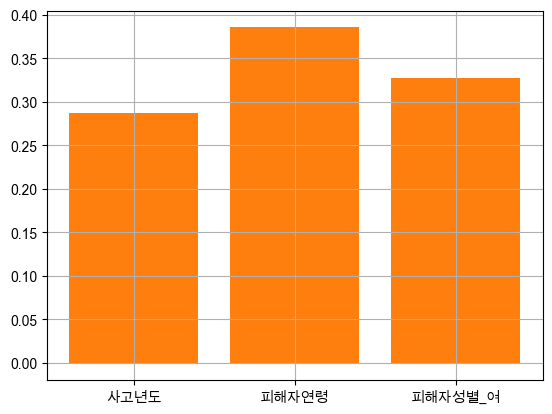

In [55]:
# 4-4. 4-3 데이터를 가지고 ‘피해자신체상해정도’ 을 종속변수로 하여 로지스틱회귀분석, XGB 분류 분류 모델을 만들고 성능 비교를 하고 영향력 있는 변수를 확인하라
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from matplotlib import font_manager,rc
font_path='/Library/Fonts/Arial Unicode.ttf'
font=font_manager.FontProperties(fname=font_path).get_name()
rc('font',family=font)
X_train, X_test, y_train, y_test=train_test_split(X_smote,y_smote,train_size=0.2)

#LogisticRegression
model_lr=LogisticRegression()
model_lr.fit(X_train,y_train)
model_lr_pred=model_lr.predict(X_test)
print(classification_report(y_test,model_lr_pred))

plt.bar(height=model_lr.coef_[0],x=model_lr.feature_names_in_)

#XGBClassifier
y_smote_XGB=le.fit_transform(y_smote)
X_train, X_test, y_train, y_test=train_test_split(X_smote,y_smote_XGB,train_size=0.2)

model_XGB=XGBClassifier()
model_XGB.fit(X_train,y_train)
model_XGB_pred=model_XGB.predict(X_test)
print(classification_report(y_test,model_XGB_pred))

plt.bar(height=model_XGB.feature_importances_,x=model_XGB.feature_names_in_)
plt.grid()
plt.show()


In [ ]:
# 문제5) 3개의 공장에서 생산한 제품을 3지역으로 가능한 조건에 맞게 최대로 배송한다. 각 공장과 각 지역 사이의 1개 제품 배송 비용이 아래와 같을 때, 최소 배송 비용은 얼마인가?
df_5=pd.DataFrame(index=["공장A","공장B","공장C","총수요량"],columns=["지역1","지역2","지역3","총생산량"],data=[[20,5,25,75],[15,2,20,55],[3,14,17,60],[80,50,60,np.nan]])
print(df_5)

import numpy as np
from scipy.optimize import linprog

# 비용 행렬 (flatten)
costs = np.array([[20,5,25],
                  [15,2,20],
                  [3,14,17]])
c = costs.flatten()
print(c)
# min 20x0​+5x1​+25x2​+15x3​+2x4​+20x5​+3x6​+14x7​+17x8​
# 공급(공장별)
supply = [75,55,60]

# 수요(지역별)
demand = [80,50,60]

# 제약식 A_eq x = b_eq
# 각 공장 공급 제한 (행 제약)
A_eq = []
b_eq = []

# 공급 제약
for i, s in enumerate(supply):
    row = np.zeros(costs.size)
    row[i*3:(i+1)*3] = 1  # 공장 i의 전체 배송량
    A_eq.append(row)
    b_eq.append(s)

# 수요 제약
for j, d in enumerate(demand):
    row = np.zeros(costs.size)
    row[j::3] = 1  # 지역 j의 전체 공급량
    A_eq.append(row)
    b_eq.append(d)

A_eq = np.array(A_eq)
b_eq = np.array(b_eq)
print('A',A_eq)
print('b',b_eq)
# (1) 공급 제약 (행 제약)
# 각 공장의 총 운송량 = 생산량
# A: 𝑥0+𝑥1+𝑥2=75
# B: 𝑥3+𝑥4+𝑥5=55
# C: 𝑥6+𝑥7+𝑥8=60

# (2) 수요 제약 (열 제약)
# 각 지역의 총 공급량 = 수요량

# 지역1: 𝑥0+𝑥3+𝑥6=80
# 지역2: 𝑥1+𝑥4+𝑥7=50
# 지역3: 𝑥2+𝑥5+𝑥8=60

# 변수는 모두 >=0
# linprog은 항상 최소화 문제만 지원
# 최대화는 부호만 바꿔주면 됨
res = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=[(0, None)]*costs.size, method="highs")

print("최소 총 비용:", res.fun)
print("해당 운송 계획:", res.x.reshape(3,3))


      지역1  지역2  지역3  총생산량
공장A    20    5   25  75.0
공장B    15    2   20  55.0
공장C     3   14   17  60.0
총수요량   80   50   60   NaN
[20  5 25 15  2 20  3 14 17]
A [[1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [1. 0. 0. 1. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 1. 0. 0. 1.]]
b [75 55 60 80 50 60]
최소 총 비용: 2055.0
해당 운송 계획: [[ 0. 50. 25.]
 [20.  0. 35.]
 [60.  0.  0.]]


In [63]:
# 문제6) 데이터 설명 : 3개 연령층 (청년 장년 노년)의 A 헤드셋의 선호도 (1,2,3/ 범주형) 설문조사
df_6 = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/30/p6.csv')
df_6.head()
# 6-1. 연령대별로 헤드셋 선호도에 차이가 있는지를 검정하기 위한 귀무가설과 연구가설을 설정해라
# - H0: 연령대별로 헤드셋 선호도에 차이가 없다.
# - Ha: 연령대별로 헤드셋 선호도에 차이가 있다.
group_청년=df_6[df_6["나이"]=="청년"]["선호도"]
group_노년=df_6[df_6["나이"]=="노년"]["선호도"]
group_장년=df_6[df_6["나이"]=="장년"]["선호도"]

#정규성 확인
stats.shapiro(group_청년),stats.shapiro(group_노년),stats.shapiro(group_장년)


(ShapiroResult(statistic=0.7931196689605713, pvalue=1.0329673748310508e-11),
 ShapiroResult(statistic=0.7926792502403259, pvalue=4.728195612813124e-10),
 ShapiroResult(statistic=0.7931775450706482, pvalue=3.7455670565123e-08))

In [68]:
stats.kruskal(group_청년, group_노년, group_장년)
# 비모수적 분산분석(ANOVA)의 대안
# 두 집단 이상(≥2)의 중앙값 차이가 유의한지 검정하는 방법
# 데이터가 정규분포를 따르지 않거나, 분산이 균일하지 않은 경우 ANOVA 대신 사용
# 기본 아이디어
# 모든 데이터를 하나로 합쳐 순위(rank) 를 매김
# 각 그룹의 순위 평균을 비교 → 만약 집단 간 분포가 비슷하다면 순위 평균도 비슷해야 함
# 집단 간 순위 평균 차이가 크면 → 집단 간 분포가 다르다고 판단
# 3. 귀무가설 / 대립가설
# H0 (귀무가설): 모든 집단의 분포(중앙값)는 같다.
# H1 (대립가설): 적어도 하나의 집단 분포가 다르다.
# 0: 연령대별로 헤드셋 선호도에 차이가 없다. 채택


KruskalResult(statistic=0.13284905970497754, pvalue=0.9357335331393262)

In [69]:
# 7-1. 아이를 6명 가진 가정이 5 가족이고, 아들/딸을 출생할 확률은 0.5이다. 딸이 4명 이상인 가구가 3 가족 이상일 확률을 구하라
1- (0.015625+0.09375+0.234375+0.3125) 

0.34375

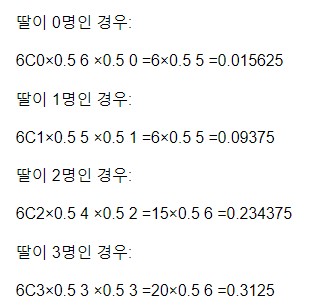